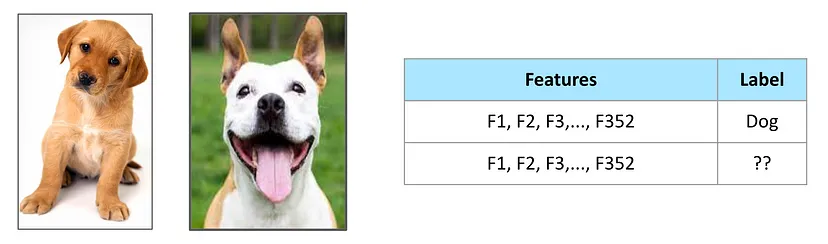

* As we may observe, this second image has a background, while the first
does not. Also, the color of the two dogs are very different. And not just that, even the expressions of the two dogs are different. All these factors are collectively called as noise. A good feature extraction approach would tend to minimise this noise, and clearly our simple approach can not do it, as it directly uses image pixel intensities
* Not just that, our simple approach is computationally expensive, as it retains lot of unnecessary information, that a good feature extraction approach may otherwise drop

# HOG

Simply put, HOG computes pixel-wise gradients and orientations, and plots them on a histogram

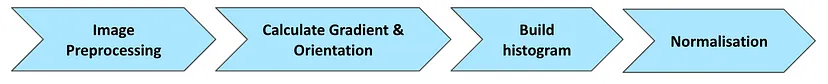

## Image Processing

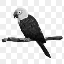

In [32]:
import cv2
from google.colab.patches import cv2_imshow
image = cv2.imread('/content/tree.jpg',cv2.IMREAD_GRAYSCALE)

resize = (64, 64)
hogsize = (4, 4)

image = cv2.resize(image, resize)
cv2_imshow(image)

## Gradient and Orientation

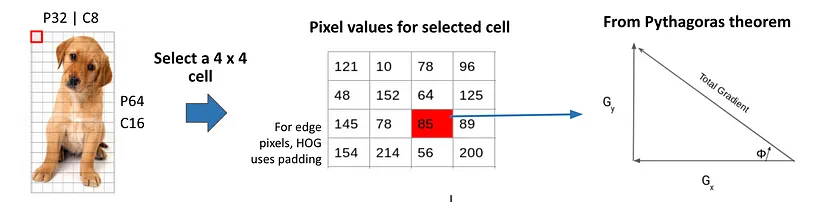

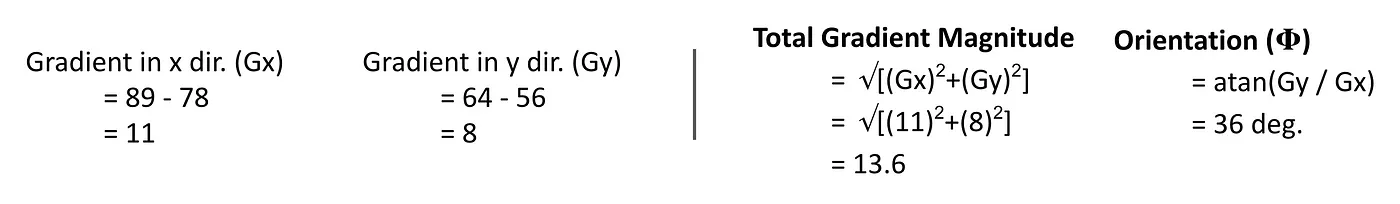

In [27]:
import numpy as np

def calculate_gradients(image):
    image = image.astype(float)
    height, width = image.shape
    gradient_x = np.zeros_like(image, dtype=float)
    gradient_y = np.zeros_like(image, dtype=float)
    padded_image = np.pad(image, ((1, 1), (1, 1)), mode='constant', constant_values=0)

    for i in range(1, height+1):
        for j in range(1, width+1):
            gradient_x[i-1, j-1] = padded_image[i, j+1] - padded_image[i, j-1]
            gradient_y[i-1, j-1] = padded_image[i-1, j] - padded_image[i+1, j]

    gradient_magnitude = np.sqrt(gradient_x**2 + gradient_y**2)
    gradient_orientation = np.arctan2(gradient_y, gradient_x)

    return gradient_magnitude, gradient_orientation

In [34]:
grad_mag, grad_orient = calculate_gradients(image)
print(grad_orient.shape)

(64, 64)


## Build histogram

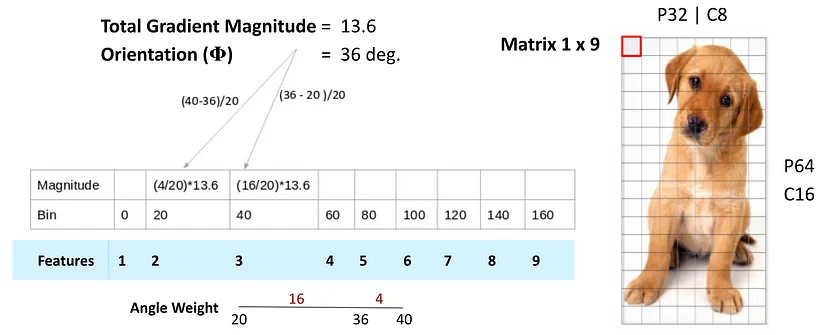

In [28]:
import numpy as np

def build_histograms(grad_magnitude, grad_orientation, cell_size=(8, 8), num_bins=9):
    height, width = grad_magnitude.shape
    cells_y, cells_x = height // cell_size[0], width // cell_size[1]

    histograms = np.zeros((cells_y, cells_x, num_bins), dtype=float)

    for i in range(cells_y):
        for j in range(cells_x):
            cell_grad_mag = grad_magnitude[i * cell_size[0]:(i + 1) * cell_size[0], j * cell_size[1]:(j + 1) * cell_size[1]]
            cell_grad_orient = grad_orientation[i * cell_size[0]:(i + 1) * cell_size[0], j * cell_size[1]:(j + 1) * cell_size[1]]

            flattened_orientations = cell_grad_orient.flatten()
            flattened_magnitudes = cell_grad_mag.flatten()

            for orientation, magnitude in zip(flattened_orientations, flattened_magnitudes):
                bin_idx1 = (int(orientation % (180 / num_bins))) % num_bins
                bin_idx2 = (bin_idx1 + 1) % num_bins
                weight1 = (orientation % (180 / num_bins)) / (180 / num_bins)
                weight2 = 1 - weight1

                histograms[i, j, bin_idx1] += weight1 * magnitude
                histograms[i, j, bin_idx2] += weight2 * magnitude

    return histograms

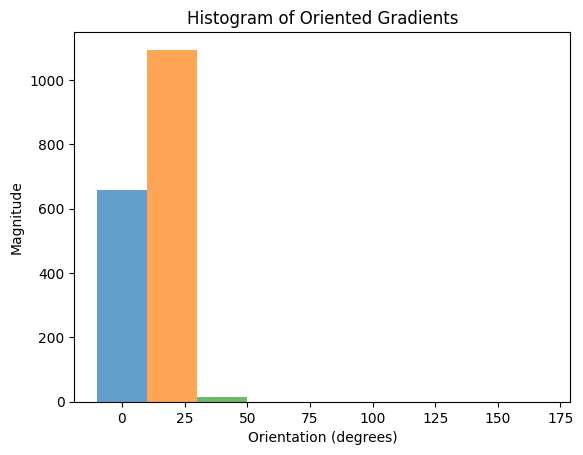

In [35]:
import matplotlib.pyplot as plt
histograms = build_histograms(grad_mag, grad_orient, hogsize)

for bin_idx in range(histograms.shape[2]):
    plt.bar(bin_idx * (180 / histograms.shape[2]), histograms[0, 0, bin_idx], width=(180 / histograms.shape[2]), alpha=0.7)

plt.title("Histogram of Oriented Gradients")
plt.xlabel("Orientation (degrees)")
plt.ylabel("Magnitude")
plt.show()

## Normalization

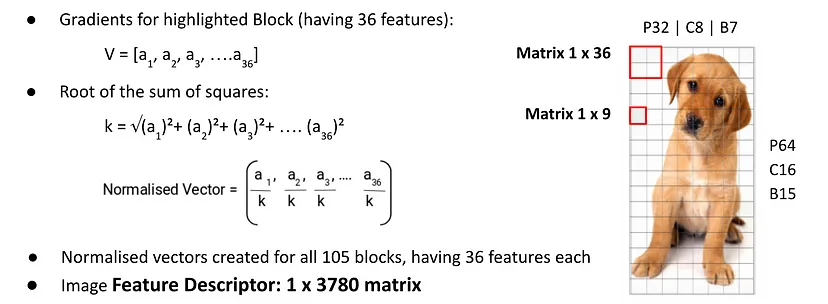

In [29]:
def normalize_blocks(histograms, block_size=(2, 2), epsilon=1e-5):
    cells_y, cells_x, num_bins = histograms.shape
    blocks_y = cells_y - block_size[0] + 1
    blocks_x = cells_x - block_size[1] + 1

    normalized_histograms = np.zeros((blocks_y, blocks_x, block_size[0], block_size[1], num_bins), dtype=float)

    for i in range(blocks_y):
        for j in range(blocks_x):
            block = histograms[i:i+block_size[0], j:j+block_size[1], :]
            block_norm = np.linalg.norm(block) + epsilon  # L2 normalization with epsilon for stability
            normalized_histograms[i, j, :, :, :] = block / block_norm

    return normalized_histograms.flatten()

In [16]:
normalized_descriptor = normalize_blocks(histograms)

print("Normalized HOG Descriptor:")
print(normalized_descriptor)

Normalized HOG Descriptor:
[0.56060847 0.44749543 0.         ... 0.         0.         0.        ]


In [17]:
normalized_descriptor.shape

(8100,)

# Classification

In [2]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
from skimage.feature import hog
from skimage import exposure

def load_data(folder_path):
    images = []
    labels = []

    for label, class_folder in enumerate(os.listdir(folder_path)):
        class_path = os.path.join(folder_path, class_folder)
        for filename in os.listdir(class_path):
            image_path = os.path.join(class_path, filename)
            img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

            if img is not None:
                img = cv2.resize(img, (64, 64))
                images.append(img)
                labels.append(label)

    return np.array(images), np.array(labels)

def custom_hog(image, cell_size=(8, 8)):
    features, hog_image = hog(image, pixels_per_cell=cell_size, block_norm='L2-Hys', visualize=True)
    hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))

    return features


dataset_path = "/content/Datasets"
data, labels = load_data(dataset_path)
hog_features = np.array([custom_hog(image) for image in data])
hog_features_standardized = hog_features.reshape(hog_features.shape[0], -1)
X_train, X_test, y_train, y_test = train_test_split(hog_features_standardized, labels, test_size=0.2, random_state=42)
svm_classifier = SVC(kernel='linear', random_state=42)
svm_classifier.fit(X_train, y_train)
y_pred = svm_classifier.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

print("Accuracy:", accuracy)
print("Classification Report:")
print(classification_rep)


Accuracy: 0.45
Classification Report:
              precision    recall  f1-score   support

           0       0.25      0.40      0.31         5
           1       0.60      0.50      0.55        18
           3       0.41      0.41      0.41        17

    accuracy                           0.45        40
   macro avg       0.42      0.44      0.42        40
weighted avg       0.48      0.45      0.46        40



In [4]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from skimage.feature import hog
from skimage import exposure

dataset_path = "/content/Datasets"
data, labels = load_data(dataset_path)
hog_features = np.array([custom_hog(image) for image in data])
hog_features_standardized = hog_features.reshape(hog_features.shape[0], -1)
X_train, X_test, y_train, y_test = train_test_split(hog_features_standardized, labels, test_size=0.2, random_state=42)

# Initialize classifiers
classifiers = {
    "SVM": SVC(kernel='linear', random_state=42),
    "KNN": KNeighborsClassifier(),
    "Naive Bayes": GaussianNB(),
    "Random Forest": RandomForestClassifier(random_state=42),
    "Logistic Regression": LogisticRegression(random_state=42),
}

results = {}
for name, classifier in classifiers.items():
    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    classification_rep = classification_report(y_test, y_pred)
    results[name] = {"accuracy": accuracy, "classification_report": classification_rep}

for name, result in results.items():
    print(f"Classifier: {name}")
    print(f"Accuracy: {result['accuracy']:.2f}")
    print("Classification Report:")
    print(result["classification_report"])
    print("-" * 50)

Classifier: SVM
Accuracy: 0.45
Classification Report:
              precision    recall  f1-score   support

           0       0.25      0.40      0.31         5
           1       0.60      0.50      0.55        18
           3       0.41      0.41      0.41        17

    accuracy                           0.45        40
   macro avg       0.42      0.44      0.42        40
weighted avg       0.48      0.45      0.46        40

--------------------------------------------------
Classifier: KNN
Accuracy: 0.40
Classification Report:
              precision    recall  f1-score   support

           0       0.33      0.60      0.43         5
           1       0.44      0.61      0.51        18
           3       0.33      0.12      0.17        17

    accuracy                           0.40        40
   macro avg       0.37      0.44      0.37        40
weighted avg       0.38      0.40      0.36        40

--------------------------------------------------
Classifier: Naive Bayes
Accu

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [5]:
classifiers = {

}

In [6]:
# Train and evaluate each classifier
results = {}
for name, classifier in classifiers.items():
    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    classification_rep = classification_report(y_test, y_pred)
    results[name] = {"accuracy": accuracy, "classification_report": classification_rep}

# Display results
for name, result in results.items():
    print(f"Classifier: {name}")
    print(f"Accuracy: {result['accuracy']:.2f}")
    print("Classification Report:")
    print(result["classification_report"])
    print("-" * 50)

Classifier: Naive Bayes
Accuracy: 0.45
Classification Report:
              precision    recall  f1-score   support

           0       0.25      0.80      0.38         5
           1       0.61      0.61      0.61        18
           3       0.50      0.18      0.26        17

    accuracy                           0.45        40
   macro avg       0.45      0.53      0.42        40
weighted avg       0.52      0.45      0.43        40

--------------------------------------------------
Classifier: Random Forest
Accuracy: 0.47
Classification Report:
              precision    recall  f1-score   support

           0       0.33      0.60      0.43         5
           1       0.55      0.67      0.60        18
           3       0.44      0.24      0.31        17

    accuracy                           0.48        40
   macro avg       0.44      0.50      0.45        40
weighted avg       0.48      0.47      0.45        40

--------------------------------------------------
Classifier

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [30]:
def hog(image, cell_size=(8,8)):
  grad_mag, grad_orient = calculate_gradients(image)
  histograms = build_histograms(grad_mag, grad_orient, cell_size)
  for bin_idx in range(histograms.shape[2]):
    plt.bar(bin_idx * (180 / histograms.shape[2]), histograms[0, 0, bin_idx], width=(180 / histograms.shape[2]), alpha=0.7)

  plt.title("Histogram of Oriented Gradients")
  plt.xlabel("Orientation (degrees)")
  plt.ylabel("Magnitude")
  plt.show()
  normalized = normalize_blocks(histograms)
  return normalized

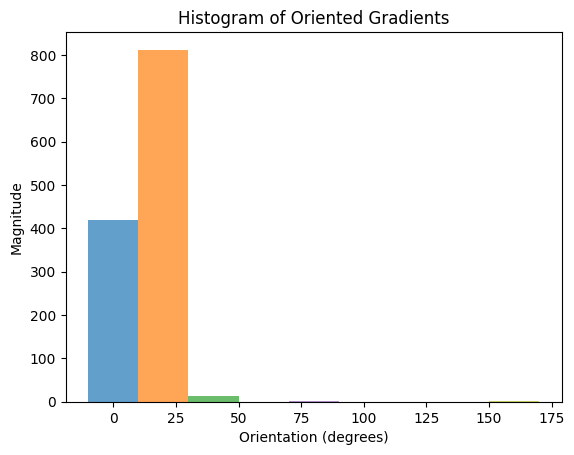

In [31]:
import cv2
from google.colab.patches import cv2_imshow
img = cv2.imread('/content/Datasets/atypicalNevus/IMD004.png', cv2.IMREAD_GRAYSCALE)

feature = hog(img)

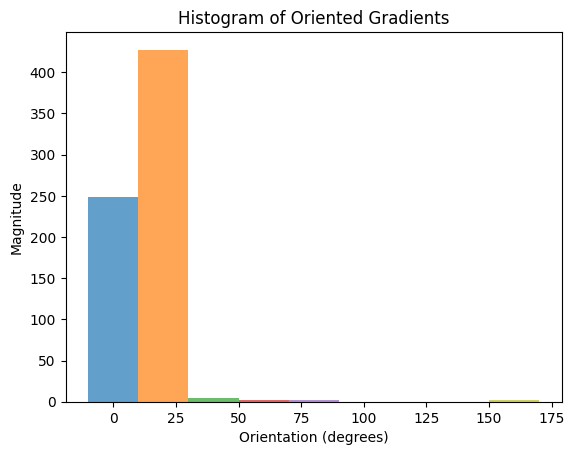

In [36]:
img = cv2.imread('/content/Datasets/commonNevus/IMD045.png', cv2.IMREAD_GRAYSCALE)

feature = hog(img)

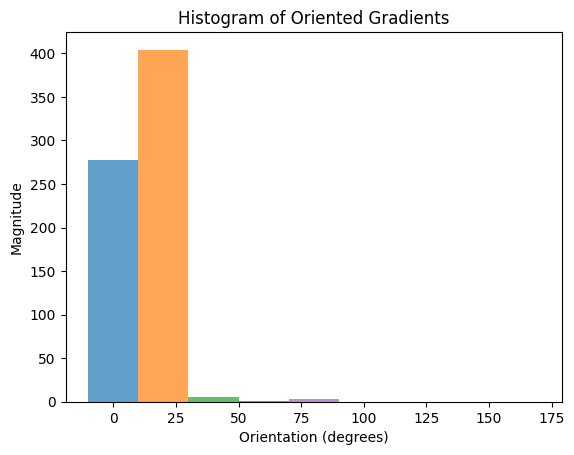

In [37]:
img = cv2.imread('/content/Datasets/melonama/IMD063.png', cv2.IMREAD_GRAYSCALE)

feature = hog(img)

In [38]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from skimage.feature import hog
from skimage import exposure

import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
from skimage.feature import hog
from skimage import exposure

def load_data(folder_path):
    images = []
    labels = []

    for label, class_folder in enumerate(os.listdir(folder_path)):
        class_path = os.path.join(folder_path, class_folder)
        for filename in os.listdir(class_path):
            image_path = os.path.join(class_path, filename)
            img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

            if img is not None:
                img = cv2.resize(img, (64, 64))
                images.append(img)
                labels.append(label)

    return np.array(images), np.array(labels)

def custom_hog(image, cell_size=(8, 8)):
    features, hog_image = hog(image, pixels_per_cell=cell_size, block_norm='L2-Hys', visualize=True)
    hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))

    return features

dataset_path = "/content/Datasets"
data, labels = load_data(dataset_path)
hog_features = np.array([custom_hog(image) for image in data])
hog_features_standardized = hog_features.reshape(hog_features.shape[0], -1)
X_train, X_test, y_train, y_test = train_test_split(hog_features_standardized, labels, test_size=0.2, random_state=42)

classifiers = {
    "SVM": SVC(kernel='linear', random_state=42),
    "KNN": KNeighborsClassifier(),
    "Naive Bayes": GaussianNB(),
    "Random Forest": RandomForestClassifier(random_state=42),
    "Logistic Regression": LogisticRegression(random_state=42),
}

results = {}
for name, classifier in classifiers.items():
    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    classification_rep = classification_report(y_test, y_pred)
    results[name] = {"accuracy": accuracy, "classification_report": classification_rep}

for name, result in results.items():
    print(f"Classifier: {name}")
    print(f"Accuracy: {result['accuracy']:.2f}")
    print("Classification Report:")
    print(result["classification_report"])
    print("-" * 50)

Classifier: SVM
Accuracy: 0.45
Classification Report:
              precision    recall  f1-score   support

           0       0.25      0.40      0.31         5
           1       0.60      0.50      0.55        18
           3       0.41      0.41      0.41        17

    accuracy                           0.45        40
   macro avg       0.42      0.44      0.42        40
weighted avg       0.48      0.45      0.46        40

--------------------------------------------------
Classifier: KNN
Accuracy: 0.40
Classification Report:
              precision    recall  f1-score   support

           0       0.33      0.60      0.43         5
           1       0.44      0.61      0.51        18
           3       0.33      0.12      0.17        17

    accuracy                           0.40        40
   macro avg       0.37      0.44      0.37        40
weighted avg       0.38      0.40      0.36        40

--------------------------------------------------
Classifier: Naive Bayes
Accu

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


# **Filter built from scratch**

In [44]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

# Your custom hog function
def hog(image, cell_size=(8, 8)):
    grad_mag, grad_orient = calculate_gradients(image)
    histograms = build_histograms(grad_mag, grad_orient, cell_size)
    normalized = normalize_blocks(histograms)
    return normalized.flatten()  # Flatten the 3D array into a 1D array

def load_data(folder_path):
    images = []
    labels = []

    for label, class_folder in enumerate(os.listdir(folder_path)):
        class_path = os.path.join(folder_path, class_folder)
        for filename in os.listdir(class_path):
            image_path = os.path.join(class_path, filename)
            img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

            if img is not None:
                images.append(img)
                labels.append(label)

    return np.array(images), np.array(labels)

dataset_path = "/content/Datasets"
data, labels = load_data(dataset_path)
hog_features = np.array([hog(image) for image in data])
hog_features_standardized = hog_features.reshape(hog_features.shape[0], -1)

X_train, X_test, y_train, y_test = train_test_split(hog_features_standardized, labels, test_size=0.2, random_state=42)

classifiers = {
    "SVM": SVC(kernel='linear', random_state=42),
    "KNN": KNeighborsClassifier(),
    "Naive Bayes": GaussianNB(),
    "Random Forest": RandomForestClassifier(random_state=42),
    "Logistic Regression": LogisticRegression(random_state=42),
}

results = {}
for name, classifier in classifiers.items():
    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    classification_rep = classification_report(y_test, y_pred)
    results[name] = {"accuracy": accuracy, "classification_report": classification_rep}

for name, result in results.items():
    print(f"Classifier: {name}")
    print(f"Accuracy: {result['accuracy']:.2f}")
    print("Classification Report:")
    print(result["classification_report"])
    print("-" * 50)


Classifier: SVM
Accuracy: 0.55
Classification Report:
              precision    recall  f1-score   support

           0       0.56      1.00      0.71         5
           1       0.60      0.50      0.55        18
           3       0.50      0.47      0.48        17

    accuracy                           0.55        40
   macro avg       0.55      0.66      0.58        40
weighted avg       0.55      0.55      0.54        40

--------------------------------------------------
Classifier: KNN
Accuracy: 0.47
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         5
           1       0.50      0.94      0.65        18
           3       0.40      0.12      0.18        17

    accuracy                           0.48        40
   macro avg       0.30      0.35      0.28        40
weighted avg       0.40      0.47      0.37        40

--------------------------------------------------
Classifier: Naive Bayes
Accu

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


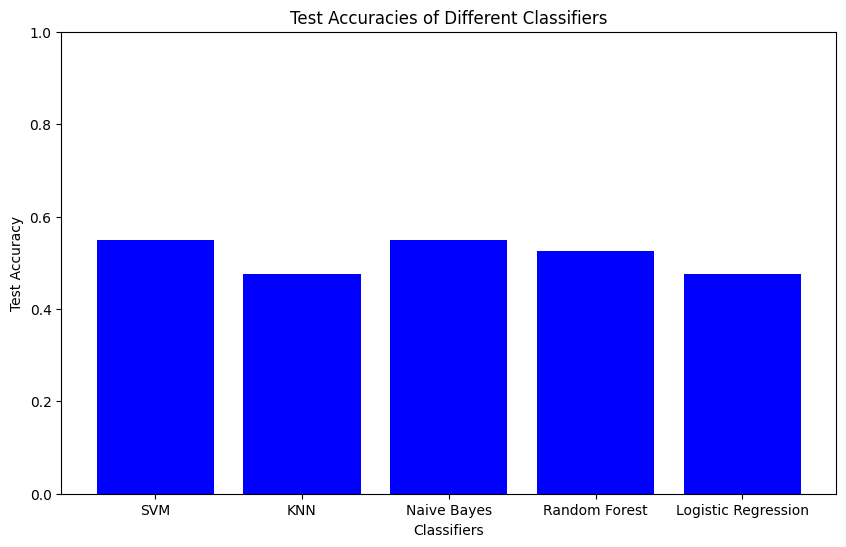

In [45]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt

# Your custom hog function and other functions

def plot_test_accuracies(accuracies):
    classifiers = list(accuracies.keys())
    values = list(accuracies.values())

    plt.figure(figsize=(10, 6))
    plt.bar(classifiers, values, color='blue')
    plt.title('Test Accuracies of Different Classifiers')
    plt.xlabel('Classifiers')
    plt.ylabel('Test Accuracy')
    plt.ylim(0, 1.0)  # Set the y-axis limit to 0-1 for accuracy values
    plt.show()

def main():
    dataset_path = "/content/Datasets"
    data, labels = load_data(dataset_path)

    # Extract HOG features using your custom hog function
    hog_features = np.array([hog(image) for image in data])
    hog_features_standardized = hog_features.reshape(hog_features.shape[0], -1)

    X_train, X_test, y_train, y_test = train_test_split(hog_features_standardized, labels, test_size=0.2, random_state=42)

    classifiers = {
        "SVM": SVC(kernel='linear', random_state=42),
        "KNN": KNeighborsClassifier(),
        "Naive Bayes": GaussianNB(),
        "Random Forest": RandomForestClassifier(random_state=42),
        "Logistic Regression": LogisticRegression(random_state=42),
    }

    accuracies = {}
    for name, classifier in classifiers.items():
        classifier.fit(X_train, y_train)
        y_pred = classifier.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        classification_rep = classification_report(y_test, y_pred)
        accuracies[name] = accuracy

    plot_test_accuracies(accuracies)

if __name__ == "__main__":
    main()


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.9/90.9 kB 1.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.8/55.8 kB 4.1 MB/s eta 0:00:00
  Created wheel for umap-learn: filename=umap_learn-0.5.5-py3-none-any.whl size=86832 sha256=0280fb09bb16037b2cab50e73f217b99120b2a063f83e0a69d22dbc41b0343cc
  Stored in directory: /root/.cache/pip/wheels/3a/70/07/428d2b58660a1a3b431db59b806a10da736612ebbc66c1bcc5
Successfully built umap-learn


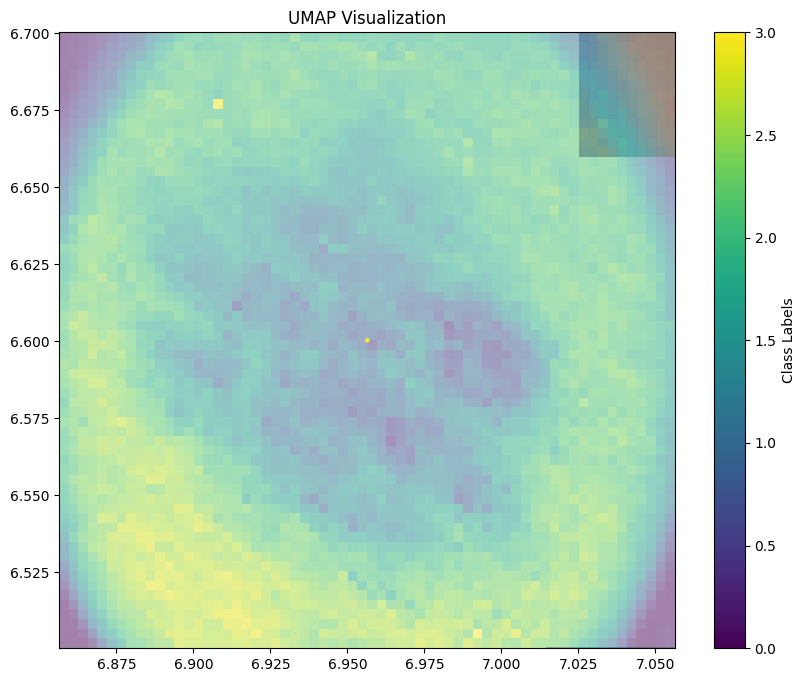

In [47]:
!pip install umap-learn

import os
import cv2
import numpy as np
import umap
import matplotlib.pyplot as plt

def load_data(folder_path):
    images = []
    labels = []

    for label, class_folder in enumerate(os.listdir(folder_path)):
        class_path = os.path.join(folder_path, class_folder)
        for filename in os.listdir(class_path):
            image_path = os.path.join(class_path, filename)
            img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

            if img is not None:
                img = cv2.resize(img, (64, 64))
                images.append(img)
                labels.append(label)

    return np.array(images), np.array(labels)

def plot_umap(embeddings, labels, images, title="UMAP Visualization"):
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(embeddings[:, 0], embeddings[:, 1], c=labels, cmap='viridis', s=5)
    plt.colorbar(scatter, orientation='vertical', label='Class Labels')
    plt.title(title)

    # Overlay images on the plot
    for i in range(len(images)):
        plt.imshow(images[i], extent=(embeddings[i, 0]-0.1, embeddings[i, 0]+0.1, embeddings[i, 1]-0.1, embeddings[i, 1]+0.1), alpha=0.5)

    plt.show()

def main():
    dataset_path = "/content/Datasets"
    data, labels = load_data(dataset_path)

    # Extract HOG features using your custom hog function
    hog_features = np.array([hog(image) for image in data])
    hog_features_standardized = hog_features.reshape(hog_features.shape[0], -1)
    reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2, metric='euclidean')
    embeddings = reducer.fit_transform(hog_features_standardized)

    plot_umap(embeddings, labels, data)

if __name__ == "__main__":
    main()
